# Linearización de la función objetivo (opción 1)

Para eliminar el término no lineal `P[i][j] * P[k][l]` (prohibido en PuLP porque es un producto de variables de decisión), se introduce una variable binaria auxiliar `y[i,k,e]` que representa el AND entre `P[i][j]` y `P[k][l]` para cada arista de adyacencia `e = (j,l)` del grafo de posiciones.

- Aristas: usamos solo pares `(j,l)` con `j < l` y `MA[j][l] == 1` para contar cada adyacencia una sola vez.
- Variables auxiliares: `y[i,k,e] ∈ {0,1}`.
- Restricciones de enlace (McCormick para binarias):
  - `y[i,k,e] ≤ P[i][j]`
  - `y[i,k,e] ≤ P[k][l]`
  - `y[i,k,e] ≥ P[i][j] + P[k][l] − 1`
- Nueva función objetivo: `min Σ_{i,k,e} CA[i][k] * y[i,k,e]`.

Además, se corrigen:
- Conteo por tipo: `Σ_j P[i][j] == ci[i]` (en lugar de `== 1`).
- Una planta por posición: `Σ_i P[i][j] == 1`.
- Se elimina la restricción "máximo 6 adyacentes" porque no era consistente con los índices ni con la lógica del modelo.
- Se ajusta la impresión de resultados para mostrar la asignación `posición → tipo` y se omiten precios sombra (no aplican en MILP).

In [10]:
from pulp import LpMaximize, LpProblem, LpVariable, value, LpMinimize

# Definir el problema
prob = LpProblem("Dummy_reto", LpMinimize)

# Definir las variables
# P[i][j] = 1 si la planta de tipo i se ubica en la posición j
# i in {0..4}, j in {0..29}
P = [[LpVariable(f"P_{i+1}_{j+1}", lowBound=0, upBound=1, cat="Binary") for j in range(30)] for i in range(5)]

# Parámetros
ci = [5, 6, 4, 7, 8]  # Cantidad de plantas por tipo i (suma = 30)

# matriz de sinergia entre plantas (i,k)
CA = [
    [0.8, 0.6, 0.9, 0.7, 0.5],
    [0.6, 0.7, 0.8, 0.9, 0.4],
    [0.9, 0.8, 0.7, 0.6, 0.3],
    [0.7, 0.9, 0.6, 0.8, 0.2],
    [0.5, 0.4, 0.3, 0.2, 0.1],
]

# Matriz de adyacencia entre posiciones (j,l)
MA = [
    # fila 1
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # fila 2
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # fila 3
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # fila 4
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    # fila 5
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
    # fila 6
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
]

# Construir lista de aristas (j,l) con j<l y MA[j][l]==1
edges = [(j, l) for j in range(30) for l in range(j + 1, 30) if MA[j][l] == 1]
E = range(len(edges))

# Variables auxiliares y[i][k][e] binarias para el producto P[i][j] AND P[k][l] donde edges[e]=(j,l)
y = [[[LpVariable(f"y_{i+1}_{k+1}_{e}", lowBound=0, upBound=1, cat="Binary") for e in E] for k in range(5)] for i in range(5)]

# Función objetivo (linearizada): sum(CA[i][k] * y[i,k,e])
prob += sum(CA[i][k] * y[i][k][e] for i in range(5) for k in range(5) for e in E), "Z"

# Restricciones de McCormick para binarias: y <= P[i][j], y <= P[k][l], y >= P[i][j] + P[k][l] - 1
for e, (j, l) in enumerate(edges):
    for i in range(5):
        for k in range(5):
            prob += y[i][k][e] <= P[i][j]
            prob += y[i][k][e] <= P[k][l]
            prob += y[i][k][e] >= P[i][j] + P[k][l] - 1

# Restricciones de asignación
# 1) Cantidad por tipo: sum_j P[i][j] == ci[i]
for i in range(5):
    prob += sum(P[i][j] for j in range(30)) == ci[i]

# 2) Una planta por posición: sum_i P[i][j] == 1
for j in range(30):
    prob += sum(P[i][j] for i in range(5)) == 1

# Resolver el problema
prob.solve()

# Imprimir resultados
print(f"Valor mínimo de Z: {value(prob.objective):.4f}")

# Mostrar asignación posición -> tipo
assignment = {}
for j in range(30):
    for i in range(5):
        if P[i][j].varValue is not None and P[i][j].varValue > 0.5:
            assignment[j + 1] = i + 1
            break

print("Asignación (posición -> tipo):")
for pos in sorted(assignment.keys()):
    print(f"Posición {pos:2d} -> Tipo {assignment[pos]}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/renec/clases/bioinspirados/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/a2cd62bd81074f46aedff1d33b889ab0-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/a2cd62bd81074f46aedff1d33b889ab0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4690 COLUMNS
At line 20791 RHS
At line 25477 BOUNDS
At line 27178 ENDATA
Problem MODEL has 4685 rows, 1700 columns and 11150 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 2380 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2780 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2792 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2770 strengthened rows, 0 substitutions


KeyboardInterrupt: 

In [ ]:
from pulp import LpMaximize, LpProblem, LpVariable, value, LpMinimize

# Definir el problema
prob = LpProblem("Dummy_reto", LpMinimize)

# Variables de decisión: P[i][j] = 1 si planta tipo i está en posición j
P = [[LpVariable(f"P_{i+1}_{j+1}", cat="Binary") for j in range(30)] for i in range(5)]

# Parámetros
ci = [5, 6, 4, 7, 8]  # Cantidad por tipo
CA = [  # Sinergia entre tipos
    [0.8, 0.6, 0.9, 0.7, 0.5],
    [0.6, 0.7, 0.8, 0.9, 0.4],
    [0.9, 0.8, 0.7, 0.6, 0.3],
    [0.7, 0.9, 0.6, 0.8, 0.2],
    [0.5, 0.4, 0.3, 0.2, 0.1],
]

# Matriz de adyacencia MA[j][l]
MA = [
    # fila 1
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # fila 2
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # fila 3
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # fila 4
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    # fila 5
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
    # fila 6
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
]

# Construir lista de aristas (j,l) con j<l y MA[j][l]==1
edges = [(j, l) for j in range(30) for l in range(j + 1, 30) if MA[j][l] == 1]
E = range(len(edges))

# Variables auxiliares y[i][k][e] solo si CA[i][k] > 0
y = {}
for i in range(5):
    for k in range(5):
        if CA[i][k] > 0:
            for e, (j, l) in enumerate(edges):
                y[i, k, e] = LpVariable(f"y_{i+1}_{k+1}_{e}", cat="Binary")

# Función objetivo
prob += sum(CA[i][k] * y[i, k, e] for (i, k, e) in y), "Z"

# Restricciones McCormick
for (i, k, e), var in y.items():
    j, l = edges[e]
    prob += var <= P[i][j]
    prob += var <= P[k][l]
    prob += var >= P[i][j] + P[k][l] - 1

# Restricciones de cantidad por tipo
for i in range(5):
    prob += sum(P[i][j] for j in range(30)) == ci[i]

# Restricciones de una planta por posición
for j in range(30):
    prob += sum(P[i][j] for i in range(5)) == 1

# Resolver
prob.solve()

# Resultados
print(f"Valor mínimo de Z: {value(prob.objective):.4f}")
assignment = {}
for j in range(30):
    for i in range(5):
        if P[i][j].varValue and P[i][j].varValue > 0.5:
            assignment[j + 1] = i + 1
            break

print("Asignación (posición -> tipo):")
for pos in sorted(assignment):
    print(f"Posición {pos:2d} -> Tipo {assignment[pos]}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/renec/clases/bioinspirados/.venv/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/linux/i64/cbc /tmp/e1822944508c4864a3584e8e40817a72-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/e1822944508c4864a3584e8e40817a72-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4690 COLUMNS
At line 20791 RHS
At line 25477 BOUNDS
At line 27178 ENDATA
Problem MODEL has 4685 rows, 1700 columns and 11150 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.01 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 2379 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2781 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2787 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 2782 strengthened rows, 0 substitutions


KeyboardInterrupt: 

# Algoritmo de Colonia de Hormigas (ACO) para el problema de asignación

El **Ant Colony Optimization (ACO)** es una metaheurística bioinspirada que simula el comportamiento de las hormigas buscando comida. Las hormigas depositan feromonas en los caminos que recorren, y las rutas con más feromonas atraen más hormigas (refuerzo positivo).

## Adaptación al problema de asignación de plantas

1. **Representación de la solución**: Cada hormiga construye una asignación completa de plantas (tipo i → posición j) respetando las restricciones:
   - Exactamente `ci[i]` plantas del tipo `i`.
   - Exactamente una planta por posición.

2. **Feromonas τ[i][j]**: Matriz que indica qué tan "bueno" es asignar el tipo `i` a la posición `j`.

3. **Heurística η[i][j]**: Información local que guía la construcción. Usamos la suma de sinergias potenciales con las posiciones adyacentes ya ocupadas.

4. **Construcción de soluciones**: 
   - Cada hormiga construye iterativamente su solución eligiendo (tipo, posición) según probabilidades basadas en τ y η.
   - Usa una lista de candidatos que respeta las restricciones de conteo.

5. **Actualización de feromonas**:
   - **Evaporación**: τ[i][j] ← (1 - ρ) * τ[i][j]
   - **Depósito**: Las mejores hormigas depositan feromonas proporcionales a la calidad de su solución (menor Z = más depósito).

6. **Parámetros**:
   - `α`: Importancia de las feromonas
   - `β`: Importancia de la heurística
   - `ρ`: Tasa de evaporación (0 < ρ < 1)
   - `n_ants`: Número de hormigas por iteración
   - `n_iterations`: Número de iteraciones

## Función objetivo

Maximizamos la sinergia total: **Σ_{(j,l) adyacentes} CA[tipo_j][tipo_l]**

(Equivalente a minimizar el negativo, como en el modelo lineal)

In [ ]:
import numpy as np
import random
from collections import defaultdict

# Parámetros del problema (reutilizamos los anteriores)
ci = [5, 6, 4, 7, 8]  # Cantidad de plantas por tipo
n_tipos = len(ci)
n_posiciones = 30

# Matriz de sinergia entre tipos
CA = np.array([
    [0.8, 0.6, 0.9, 0.7, 0.5],
    [0.6, 0.7, 0.8, 0.9, 0.4],
    [0.9, 0.8, 0.7, 0.6, 0.3],
    [0.7, 0.9, 0.6, 0.8, 0.2],
    [0.5, 0.4, 0.3, 0.2, 0.1],
])

# Matriz de adyacencia entre posiciones
MA = np.array([
    # fila 1
    [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # fila 2
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # fila 3
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    # fila 4
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    # fila 5
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1],
    # fila 6
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
])

# Pre-calcular vecinos de cada posición
vecinos = defaultdict(list)
for j in range(n_posiciones):
    for l in range(n_posiciones):
        if MA[j][l] == 1:
            vecinos[j].append(l)

print(f"Problema: {n_tipos} tipos de plantas, {n_posiciones} posiciones")
print(f"Distribución por tipo: {ci}")
print(f"Total de plantas: {sum(ci)}")

Problema: 5 tipos de plantas, 30 posiciones
Distribución por tipo: [5, 6, 4, 7, 8]
Total de plantas: 30


In [ ]:
def calcular_fitness(solucion):
    """
    Calcula la sinergia total de una solución.
    solucion[j] = tipo de planta en posición j (0..4)
    Retorna la suma de sinergias CA[tipo_j][tipo_l] para todas las aristas (j,l) adyacentes.
    """
    fitness = 0.0
    for j in range(n_posiciones):
        tipo_j = solucion[j]
        for l in vecinos[j]:
            if l > j:  # Contar cada arista una sola vez
                tipo_l = solucion[l]
                fitness += CA[tipo_j][tipo_l]
    return fitness


def construir_solucion(tau, alpha, beta):
    """
    Construye una solución completa usando la matriz de feromonas tau y la heurística.
    Retorna un array donde solucion[j] = tipo de planta asignado a posición j.
    """
    solucion = np.full(n_posiciones, -1, dtype=int)
    # Contador de plantas disponibles por tipo
    disponibles = ci.copy()
    
    # Lista de posiciones no asignadas
    posiciones_libres = list(range(n_posiciones))
    
    for _ in range(n_posiciones):
        # Elegir una posición aleatoria de las libres
        j = random.choice(posiciones_libres)
        posiciones_libres.remove(j)
        
        # Calcular heurística para cada tipo disponible
        # η[i] = suma de sinergias potenciales con vecinos ya asignados
        eta = np.zeros(n_tipos)
        for i in range(n_tipos):
            if disponibles[i] > 0:
                for l in vecinos[j]:
                    if solucion[l] != -1:  # Vecino ya asignado
                        eta[i] += CA[i][solucion[l]]
                # Si no hay vecinos asignados, usar un valor base pequeño
                if eta[i] == 0:
                    eta[i] = 0.1
        
        # Calcular probabilidades para cada tipo disponible
        probs = np.zeros(n_tipos)
        for i in range(n_tipos):
            if disponibles[i] > 0:
                probs[i] = (tau[i][j] ** alpha) * (eta[i] ** beta)
        
        # Normalizar probabilidades
        suma_probs = np.sum(probs)
        if suma_probs > 0:
            probs /= suma_probs
        else:
            # Si todas las probabilidades son 0, elegir uniformemente entre disponibles
            for i in range(n_tipos):
                if disponibles[i] > 0:
                    probs[i] = 1.0
            probs /= np.sum(probs)
        
        # Elegir tipo según probabilidades
        tipo_elegido = np.random.choice(n_tipos, p=probs)
        solucion[j] = tipo_elegido
        disponibles[tipo_elegido] -= 1
    
    return solucion


print("Funciones de construcción y evaluación definidas.")

Funciones de construcción y evaluación definidas.


In [ ]:
def ant_colony_optimization(n_ants=20, n_iterations=100, alpha=1.0, beta=2.0, rho=0.1, Q=1.0):
    """
    Algoritmo de Colonia de Hormigas para el problema de asignación.
    
    Parámetros:
    - n_ants: Número de hormigas por iteración
    - n_iterations: Número de iteraciones
    - alpha: Peso de las feromonas (importancia de la experiencia previa)
    - beta: Peso de la heurística (importancia de la información local)
    - rho: Tasa de evaporación (0 < rho < 1)
    - Q: Constante para el depósito de feromonas
    
    Retorna:
    - mejor_solucion: Array con la mejor asignación encontrada
    - mejor_fitness: Fitness de la mejor solución
    - historico: Lista con el mejor fitness en cada iteración
    """
    
    # Inicializar matriz de feromonas (uniforme)
    tau = np.ones((n_tipos, n_posiciones))
    
    # Mejor solución global
    mejor_solucion = None
    mejor_fitness = -np.inf
    
    # Histórico de fitness por iteración
    historico = []
    
    print(f"Iniciando ACO: {n_ants} hormigas, {n_iterations} iteraciones")
    print(f"Parámetros: α={alpha}, β={beta}, ρ={rho}, Q={Q}\n")
    
    for iter in range(n_iterations):
        # Almacenar soluciones y fitness de esta iteración
        soluciones = []
        fitness_values = []
        
        # Cada hormiga construye una solución
        for ant in range(n_ants):
            solucion = construir_solucion(tau, alpha, beta)
            fitness = calcular_fitness(solucion)
            
            soluciones.append(solucion)
            fitness_values.append(fitness)
            
            # Actualizar mejor solución global
            if fitness > mejor_fitness:
                mejor_fitness = fitness
                mejor_solucion = solucion.copy()
        
        # Evaporación de feromonas
        tau *= (1 - rho)
        
        # Depósito de feromonas por las hormigas
        for solucion, fitness in zip(soluciones, fitness_values):
            # Solo las hormigas con buen fitness depositan (elitismo suave)
            if fitness > 0:
                delta_tau = Q * fitness
                for j in range(n_posiciones):
                    tipo = solucion[j]
                    tau[tipo][j] += delta_tau
        
        # Refuerzo extra para la mejor solución (elitismo)
        if mejor_solucion is not None:
            delta_tau_best = Q * mejor_fitness * 2  # Doble refuerzo
            for j in range(n_posiciones):
                tipo = mejor_solucion[j]
                tau[tipo][j] += delta_tau_best
        
        # Guardar histórico
        historico.append(mejor_fitness)
        
        # Imprimir progreso cada 10 iteraciones
        if (iter + 1) % 10 == 0:
            fitness_promedio = np.mean(fitness_values)
            print(f"Iteración {iter+1:3d}: Mejor fitness = {mejor_fitness:.4f}, Promedio = {fitness_promedio:.4f}")
    
    print(f"\n✓ Optimización completada!")
    print(f"Mejor fitness encontrado: {mejor_fitness:.4f}")
    
    return mejor_solucion, mejor_fitness, historico


# Ejecutar el algoritmo ACO
np.random.seed(42)
random.seed(42)

mejor_solucion, mejor_fitness, historico = ant_colony_optimization(
    n_ants=30,
    n_iterations=100,
    alpha=1.0,
    beta=2.5,
    rho=0.15,
    Q=1.0
)

Iniciando ACO: 30 hormigas, 100 iteraciones
Parámetros: α=1.0, β=2.5, ρ=0.15, Q=1.0

Iteración  10: Mejor fitness = 39.9000, Promedio = 34.9967
Iteración  20: Mejor fitness = 41.0000, Promedio = 35.4633
Iteración  30: Mejor fitness = 41.0000, Promedio = 34.7467
Iteración  40: Mejor fitness = 41.0000, Promedio = 35.2233
Iteración  50: Mejor fitness = 41.9000, Promedio = 35.0733
Iteración  60: Mejor fitness = 41.9000, Promedio = 35.0533
Iteración  70: Mejor fitness = 41.9000, Promedio = 35.1600
Iteración  80: Mejor fitness = 41.9000, Promedio = 35.5300
Iteración  90: Mejor fitness = 41.9000, Promedio = 34.8467
Iteración 100: Mejor fitness = 41.9000, Promedio = 35.8533

✓ Optimización completada!
Mejor fitness encontrado: 41.9000


In [ ]:
# Mostrar la solución encontrada
print("\n" + "="*60)
print("SOLUCIÓN ENCONTRADA POR ACO")
print("="*60)

# Verificar restricciones
conteo_por_tipo = [0] * n_tipos
for j in range(n_posiciones):
    tipo = mejor_solucion[j]
    conteo_por_tipo[tipo] += 1

print("\nVerificación de restricciones:")
print(f"Cantidad por tipo (esperado vs obtenido):")
for i in range(n_tipos):
    status = "✓" if conteo_por_tipo[i] == ci[i] else "✗"
    print(f"  Tipo {i+1}: {ci[i]} esperado, {conteo_por_tipo[i]} obtenido {status}")

# Mostrar asignación
print("\nAsignación (Posición → Tipo):")
for j in range(n_posiciones):
    tipo = mejor_solucion[j] + 1  # +1 para mostrar tipos 1-5
    print(f"  Posición {j+1:2d} → Tipo {tipo}")

# Calcular sinergia detallada
print(f"\nSinergia total: {mejor_fitness:.4f}")

# Desglose de sinergias por arista
print("\nDesglose de sinergias (solo aristas con sinergia > 0):")
sinergia_por_arista = []
for j in range(n_posiciones):
    tipo_j = mejor_solucion[j]
    for l in vecinos[j]:
        if l > j:
            tipo_l = mejor_solucion[l]
            sinergia = CA[tipo_j][tipo_l]
            if sinergia > 0:
                sinergia_por_arista.append((j+1, l+1, tipo_j+1, tipo_l+1, sinergia))

# Ordenar por sinergia descendente
sinergia_por_arista.sort(key=lambda x: x[4], reverse=True)

print(f"Top 10 mejores sinergias:")
for i, (pos_j, pos_l, tipo_j, tipo_l, sinergia) in enumerate(sinergia_por_arista[:10], 1):
    print(f"  {i:2d}. Pos {pos_j:2d} (Tipo {tipo_j}) ↔ Pos {pos_l:2d} (Tipo {tipo_l}): {sinergia:.2f}")


SOLUCIÓN ENCONTRADA POR ACO

Verificación de restricciones:
Cantidad por tipo (esperado vs obtenido):
  Tipo 1: 5 esperado, 5 obtenido ✓
  Tipo 2: 6 esperado, 6 obtenido ✓
  Tipo 3: 4 esperado, 4 obtenido ✓
  Tipo 4: 7 esperado, 7 obtenido ✓
  Tipo 5: 8 esperado, 8 obtenido ✓

Asignación (Posición → Tipo):
  Posición  1 → Tipo 3
  Posición  2 → Tipo 2
  Posición  3 → Tipo 4
  Posición  4 → Tipo 2
  Posición  5 → Tipo 1
  Posición  6 → Tipo 1
  Posición  7 → Tipo 4
  Posición  8 → Tipo 2
  Posición  9 → Tipo 3
  Posición 10 → Tipo 3
  Posición 11 → Tipo 4
  Posición 12 → Tipo 4
  Posición 13 → Tipo 4
  Posición 14 → Tipo 3
  Posición 15 → Tipo 1
  Posición 16 → Tipo 2
  Posición 17 → Tipo 1
  Posición 18 → Tipo 4
  Posición 19 → Tipo 4
  Posición 20 → Tipo 5
  Posición 21 → Tipo 5
  Posición 22 → Tipo 5
  Posición 23 → Tipo 2
  Posición 24 → Tipo 1
  Posición 25 → Tipo 5
  Posición 26 → Tipo 2
  Posición 27 → Tipo 5
  Posición 28 → Tipo 5
  Posición 29 → Tipo 5
  Posición 30 → Tipo 5



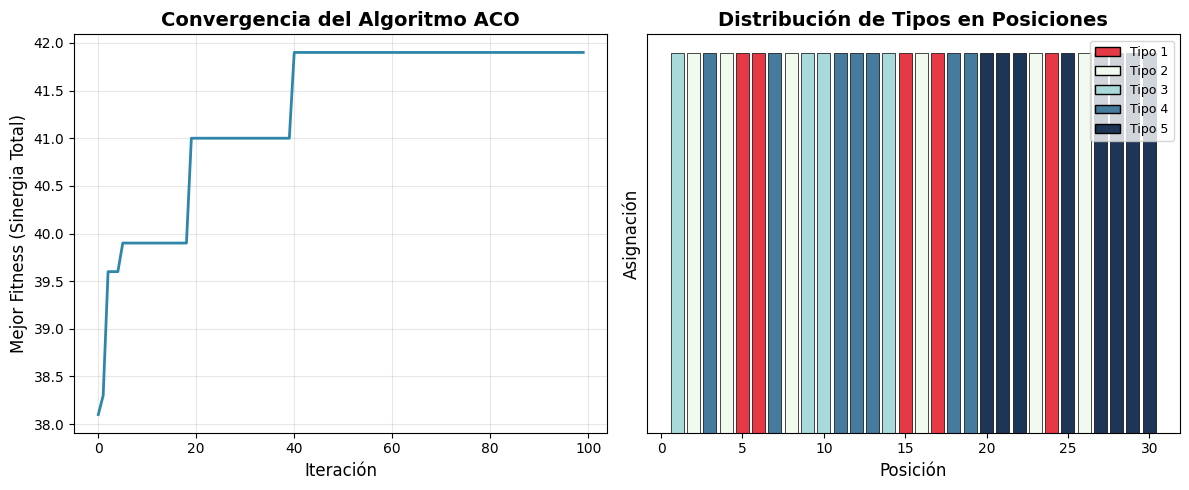


✓ Gráficas generadas


In [ ]:
import matplotlib.pyplot as plt

# Gráfica de convergencia
plt.figure(figsize=(12, 5))

# Subplot 1: Evolución del mejor fitness
plt.subplot(1, 2, 1)
plt.plot(historico, linewidth=2, color='#2E86AB')
plt.xlabel('Iteración', fontsize=12)
plt.ylabel('Mejor Fitness (Sinergia Total)', fontsize=12)
plt.title('Convergencia del Algoritmo ACO', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Subplot 2: Distribución de tipos por posición
plt.subplot(1, 2, 2)
posiciones = np.arange(1, n_posiciones + 1)
colores = ['#E63946', '#F1FAEE', '#A8DADC', '#457B9D', '#1D3557']
tipo_colores = [colores[mejor_solucion[j]] for j in range(n_posiciones)]

plt.bar(posiciones, [1]*n_posiciones, color=tipo_colores, edgecolor='black', linewidth=0.5)
plt.xlabel('Posición', fontsize=12)
plt.ylabel('Asignación', fontsize=12)
plt.title('Distribución de Tipos en Posiciones', fontsize=14, fontweight='bold')
plt.yticks([])

# Leyenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colores[i], edgecolor='black', label=f'Tipo {i+1}') for i in range(n_tipos)]
plt.legend(handles=legend_elements, loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Gráficas generadas")

# Alternativas eficientes para representar la matriz de adyacencia

Para grafos con 600+ nodos, la matriz de adyacencia NxN es **muy ineficiente**:
- **Memoria**: 600×600 = 360,000 elementos (incluso si la mayoría son 0)
- **Tiempo**: Iterar sobre toda la matriz es O(N²)

## Alternativas más eficientes

### 1. **Lista de adyacencia (diccionario)** ⭐ RECOMENDADO
Almacena solo los vecinos reales de cada nodo. Ideal para grafos dispersos (pocos vecinos por nodo).

```python
# En lugar de matriz 30x30:
vecinos = {
    0: [1, 5],
    1: [0, 2, 5, 6],
    2: [1, 3, 6, 7],
    # ...
}
```
- **Memoria**: O(N + E) donde E = número de aristas
- **Acceso a vecinos**: O(1) promedio
- **Espacio típico para 600 nodos con ~6 vecinos/nodo**: ~3,600 entradas vs 360,000

### 2. **Lista de aristas (tuplas)**
Almacena solo las conexiones existentes.

```python
edges = [(0, 1), (0, 5), (1, 2), (1, 5), (1, 6), ...]
```
- **Memoria**: O(E)
- **Útil para**: Iterar sobre todas las aristas sin revisar ceros

### 3. **Matriz dispersa (scipy.sparse)**
Usa estructuras optimizadas para matrices con muchos ceros.

```python
from scipy.sparse import csr_matrix
MA_sparse = csr_matrix(MA)  # Compressed Sparse Row
```
- **Memoria**: Solo almacena valores no-cero
- **Operaciones matriciales**: Optimizadas para sparse

### 4. **Representación geométrica (para grids regulares)**
Si tus nodos están en un grid/lattice regular, calcula vecinos on-the-fly.

```python
def obtener_vecinos_grid(pos, filas, cols):
    # Para grid hexagonal/triangular
    vecinos = []
    # Calcular basado en fórmula geométrica
    return vecinos
```
- **Memoria**: O(1) - sin almacenamiento
- **Ideal para**: Patrones geométricos regulares

---

## Comparación de rendimiento (600 nodos, ~6 vecinos promedio)

| Representación | Memoria | Obtener vecinos | Iterar aristas |
|----------------|---------|-----------------|----------------|
| Matriz densa   | 360,000 | O(N) escaneo    | O(N²)         |
| Lista adj.     | ~3,600  | O(1)            | O(E)          |
| Lista aristas  | ~1,800  | O(E) búsqueda   | O(E)          |
| Sparse matrix  | ~3,600  | O(k) k=vecinos  | O(E)          |
| Grid geométrico| 0       | O(1) cálculo    | O(N)          |

**Para ACO con 600+ nodos: Lista de adyacencia es la mejor opción** ✓

In [ ]:
# DEMO: Conversión de matriz densa a lista de adyacencia eficiente

import time
import sys

print("="*70)
print("COMPARACIÓN DE EFICIENCIA: Matriz densa vs Lista de adyacencia")
print("="*70)

# 1. Matriz densa (actual)
print("\n1️⃣  MATRIZ DENSA (actual)")
print(f"   Tamaño: {MA.shape}")
print(f"   Elementos totales: {MA.size:,}")
print(f"   Elementos no-cero: {np.count_nonzero(MA):,}")
print(f"   Memoria: {sys.getsizeof(MA):,} bytes")

# Tiempo de acceso a vecinos (repetido 1000 veces)
start = time.time()
for _ in range(1000):
    for j in range(n_posiciones):
        vecinos_j = [l for l in range(n_posiciones) if MA[j][l] == 1]
time_dense = time.time() - start
print(f"   Tiempo buscar vecinos (1000 iter): {time_dense:.4f}s")

print("\n" + "-"*70)

# 2. Lista de adyacencia (eficiente)
print("\n2️⃣  LISTA DE ADYACENCIA (eficiente)")

# Construir desde la matriz (solo una vez)
vecinos_dict = {}
for j in range(n_posiciones):
    vecinos_dict[j] = [l for l in range(n_posiciones) if MA[j][l] == 1]

print(f"   Estructura: diccionario")
print(f"   Nodos: {len(vecinos_dict)}")
total_vecinos = sum(len(v) for v in vecinos_dict.values())
print(f"   Total vecinos almacenados: {total_vecinos:,}")
print(f"   Promedio vecinos/nodo: {total_vecinos/len(vecinos_dict):.2f}")
print(f"   Memoria: {sys.getsizeof(vecinos_dict) + sum(sys.getsizeof(v) for v in vecinos_dict.values()):,} bytes")

# Tiempo de acceso (mismo test)
start = time.time()
for _ in range(1000):
    for j in range(n_posiciones):
        vecinos_j = vecinos_dict[j]  # Acceso directo O(1)
time_list = time.time() - start
print(f"   Tiempo acceso vecinos (1000 iter): {time_list:.4f}s")

print("\n" + "-"*70)

# 3. Lista de aristas (alternativa)
print("\n3️⃣  LISTA DE ARISTAS (alternativa)")

# Solo almacenar aristas únicas (j < l)
edges_list = [(j, l) for j in range(n_posiciones) for l in range(j+1, n_posiciones) if MA[j][l] == 1]

print(f"   Estructura: lista de tuplas")
print(f"   Número de aristas: {len(edges_list):,}")
print(f"   Memoria: {sys.getsizeof(edges_list) + sum(sys.getsizeof(e) for e in edges_list[:10])*len(edges_list)//10:,} bytes (aprox)")

print("\n" + "="*70)
print("RESULTADOS")
print("="*70)
print(f"⚡ Speedup lista de adyacencia: {time_dense/time_list:.1f}x más rápido")
print(f"💾 Reducción de memoria: ~{(MA.size - total_vecinos)/MA.size*100:.1f}%")

# Extrapolación a 600 nodos
print("\n" + "="*70)
print("PROYECCIÓN PARA 600 NODOS")
print("="*70)
n_grande = 600
vecinos_promedio = total_vecinos / n_posiciones
print(f"Asumiendo {vecinos_promedio:.1f} vecinos/nodo en promedio:")
print(f"")
print(f"Matriz densa:")
print(f"  • Elementos: {n_grande**2:,}")
print(f"  • Memoria: ~{n_grande**2 * 8 / 1024 / 1024:.2f} MB (float64)")
print(f"")
print(f"Lista de adyacencia:")
print(f"  • Entradas: ~{int(n_grande * vecinos_promedio):,}")
print(f"  • Memoria: ~{int(n_grande * vecinos_promedio) * 8 / 1024:.2f} KB")
print(f"")
print(f"🎯 Conclusión: Para 600 nodos, usa lista de adyacencia (dict)")
print(f"   Reducción de memoria: ~{100 - (vecinos_promedio/n_grande*100):.1f}%")

In [ ]:
# FUNCIÓN HELPER: Convertir matriz de adyacencia a formato eficiente

def convertir_a_lista_adyacencia(matriz):
    """
    Convierte una matriz de adyacencia NxN a un diccionario de listas.
    
    Args:
        matriz: numpy array o lista de listas NxN (valores 0 o 1)
    
    Returns:
        dict: {nodo: [lista de vecinos]}
    """
    n = len(matriz)
    vecinos = {}
    for j in range(n):
        vecinos[j] = [l for l in range(n) if matriz[j][l] == 1]
    return vecinos


def cargar_desde_archivo_eficiente(filepath):
    """
    Carga un grafo desde archivo en formato de lista de adyacencia.
    
    Formato del archivo (cada línea):
        nodo: vecino1,vecino2,vecino3,...
    
    Ejemplo:
        0: 1,5
        1: 0,2,5,6
        2: 1,3,6,7
    """
    vecinos = {}
    with open(filepath, 'r') as f:
        for linea in f:
            if ':' in linea:
                nodo, vecinos_str = linea.strip().split(':')
                nodo = int(nodo)
                if vecinos_str.strip():
                    vecinos[nodo] = [int(v) for v in vecinos_str.split(',')]
                else:
                    vecinos[nodo] = []
    return vecinos


def guardar_lista_adyacencia(vecinos, filepath):
    """
    Guarda un grafo en formato de lista de adyacencia.
    
    Args:
        vecinos: dict {nodo: [lista de vecinos]}
        filepath: ruta del archivo a crear
    """
    with open(filepath, 'w') as f:
        for nodo in sorted(vecinos.keys()):
            vecinos_str = ','.join(map(str, vecinos[nodo]))
            f.write(f"{nodo}: {vecinos_str}\n")
    print(f"✓ Grafo guardado en {filepath}")


def calcular_estadisticas_grafo(vecinos):
    """
    Calcula estadísticas del grafo.
    
    Returns:
        dict con n_nodos, n_aristas, grado_promedio, grado_max, grado_min
    """
    n_nodos = len(vecinos)
    grados = [len(vecinos[j]) for j in vecinos]
    n_aristas = sum(grados) // 2  # Cada arista se cuenta 2 veces
    
    return {
        'n_nodos': n_nodos,
        'n_aristas': n_aristas,
        'grado_promedio': sum(grados) / n_nodos,
        'grado_max': max(grados),
        'grado_min': min(grados),
        'densidad': n_aristas / (n_nodos * (n_nodos - 1) / 2) if n_nodos > 1 else 0
    }


# Ejemplo de uso con nuestro problema
vecinos_eficiente = convertir_a_lista_adyacencia(MA)

print("✓ Funciones helper definidas")
print("\nEjemplo: vecinos del nodo 0:", vecinos_eficiente[0])
print("         vecinos del nodo 11:", vecinos_eficiente[11])

# Estadísticas del grafo actual
stats = calcular_estadisticas_grafo(vecinos_eficiente)
print("\nEstadísticas del grafo:")
for key, value in stats.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.2f}")
    else:
        print(f"  {key}: {value}")

In [ ]:
# VERSIÓN OPTIMIZADA DEL ACO usando lista de adyacencia

def calcular_fitness_optimizado(solucion, vecinos):
    """
    Versión optimizada: usa lista de adyacencia en lugar de matriz.
    Solo itera sobre vecinos reales (mucho más rápido).
    """
    fitness = 0.0
    for j in vecinos.keys():
        tipo_j = solucion[j]
        for l in vecinos[j]:
            if l > j:  # Contar cada arista una sola vez
                tipo_l = solucion[l]
                fitness += CA[tipo_j][tipo_l]
    return fitness


def construir_solucion_optimizado(tau, vecinos, alpha, beta):
    """
    Versión optimizada que usa lista de adyacencia.
    """
    n_pos = len(vecinos)
    solucion = np.full(n_pos, -1, dtype=int)
    disponibles = ci.copy()
    posiciones_libres = list(range(n_pos))
    
    for _ in range(n_pos):
        j = random.choice(posiciones_libres)
        posiciones_libres.remove(j)
        
        # Heurística: suma de sinergias con vecinos ya asignados
        eta = np.zeros(n_tipos)
        for i in range(n_tipos):
            if disponibles[i] > 0:
                for l in vecinos[j]:  # Solo vecinos reales (eficiente)
                    if solucion[l] != -1:
                        eta[i] += CA[i][solucion[l]]
                if eta[i] == 0:
                    eta[i] = 0.1
        
        # Calcular probabilidades
        probs = np.zeros(n_tipos)
        for i in range(n_tipos):
            if disponibles[i] > 0:
                probs[i] = (tau[i][j] ** alpha) * (eta[i] ** beta)
        
        suma_probs = np.sum(probs)
        if suma_probs > 0:
            probs /= suma_probs
        else:
            for i in range(n_tipos):
                if disponibles[i] > 0:
                    probs[i] = 1.0
            probs /= np.sum(probs)
        
        tipo_elegido = np.random.choice(n_tipos, p=probs)
        solucion[j] = tipo_elegido
        disponibles[tipo_elegido] -= 1
    
    return solucion


def aco_optimizado(vecinos, n_ants=30, n_iterations=100, alpha=1.0, beta=2.5, rho=0.15, Q=1.0, verbose=True):
    """
    ACO optimizado usando lista de adyacencia.
    """
    n_pos = len(vecinos)
    tau = np.ones((n_tipos, n_pos))
    
    mejor_solucion = None
    mejor_fitness = -np.inf
    historico = []
    
    if verbose:
        print(f"🐜 ACO Optimizado: {n_ants} hormigas, {n_iterations} iter")
        print(f"📊 Grafo: {n_pos} nodos, {sum(len(v) for v in vecinos.values())//2} aristas\n")
    
    for iter in range(n_iterations):
        soluciones = []
        fitness_values = []
        
        for ant in range(n_ants):
            solucion = construir_solucion_optimizado(tau, vecinos, alpha, beta)
            fitness = calcular_fitness_optimizado(solucion, vecinos)
            
            soluciones.append(solucion)
            fitness_values.append(fitness)
            
            if fitness > mejor_fitness:
                mejor_fitness = fitness
                mejor_solucion = solucion.copy()
        
        # Actualización de feromonas
        tau *= (1 - rho)
        
        for solucion, fitness in zip(soluciones, fitness_values):
            if fitness > 0:
                delta_tau = Q * fitness
                for j in range(n_pos):
                    tipo = solucion[j]
                    tau[tipo][j] += delta_tau
        
        if mejor_solucion is not None:
            delta_tau_best = Q * mejor_fitness * 2
            for j in range(n_pos):
                tipo = mejor_solucion[j]
                tau[tipo][j] += delta_tau_best
        
        historico.append(mejor_fitness)
        
        if verbose and (iter + 1) % 20 == 0:
            print(f"Iter {iter+1:3d}: Mejor={mejor_fitness:.4f}, Prom={np.mean(fitness_values):.4f}")
    
    if verbose:
        print(f"\n✓ Mejor fitness: {mejor_fitness:.4f}")
    
    return mejor_solucion, mejor_fitness, historico


# Ejecutar versión optimizada
print("="*70)
print("EJECUTANDO ACO OPTIMIZADO (con lista de adyacencia)")
print("="*70 + "\n")

np.random.seed(42)
random.seed(42)

mejor_sol_opt, mejor_fit_opt, hist_opt = aco_optimizado(
    vecinos_eficiente,
    n_ants=30,
    n_iterations=100,
    alpha=1.0,
    beta=2.5,
    rho=0.15
)

In [ ]:
# BONUS: Generador de grafos hexagonales/triangulares eficientes para grids grandes

def generar_grid_hexagonal(filas, cols):
    """
    Genera un grid hexagonal (patrón de tres bolillos) de manera eficiente.
    Retorna lista de adyacencia.
    
    Args:
        filas: número de filas
        cols: número de columnas
    
    Returns:
        dict: {nodo_id: [vecinos]}
    """
    vecinos = {}
    
    def pos_to_id(r, c):
        return r * cols + c
    
    for r in range(filas):
        for c in range(cols):
            nodo = pos_to_id(r, c)
            vecinos[nodo] = []
            
            # Vecinos laterales
            if c > 0:
                vecinos[nodo].append(pos_to_id(r, c - 1))
            if c < cols - 1:
                vecinos[nodo].append(pos_to_id(r, c + 1))
            
            # Vecinos verticales (depende de si la fila es par o impar)
            if r > 0:
                vecinos[nodo].append(pos_to_id(r - 1, c))
                if r % 2 == 0 and c > 0:  # Fila par: vecino diagonal izq superior
                    vecinos[nodo].append(pos_to_id(r - 1, c - 1))
                elif r % 2 == 1 and c < cols - 1:  # Fila impar: vecino diagonal der superior
                    vecinos[nodo].append(pos_to_id(r - 1, c + 1))
            
            if r < filas - 1:
                vecinos[nodo].append(pos_to_id(r + 1, c))
                if r % 2 == 0 and c > 0:  # Fila par: vecino diagonal izq inferior
                    vecinos[nodo].append(pos_to_id(r + 1, c - 1))
                elif r % 2 == 1 and c < cols - 1:  # Fila impar: vecino diagonal der inferior
                    vecinos[nodo].append(pos_to_id(r + 1, c + 1))
    
    return vecinos


def generar_grid_rectangular(filas, cols):
    """
    Genera un grid rectangular 4-conectado (arriba, abajo, izq, der).
    """
    vecinos = {}
    
    def pos_to_id(r, c):
        return r * cols + c
    
    for r in range(filas):
        for c in range(cols):
            nodo = pos_to_id(r, c)
            vecinos[nodo] = []
            
            if r > 0:
                vecinos[nodo].append(pos_to_id(r - 1, c))
            if r < filas - 1:
                vecinos[nodo].append(pos_to_id(r + 1, c))
            if c > 0:
                vecinos[nodo].append(pos_to_id(r, c - 1))
            if c < cols - 1:
                vecinos[nodo].append(pos_to_id(r, c + 1))
    
    return vecinos


# Ejemplo: generar grid grande
print("="*70)
print("GENERACIÓN EFICIENTE DE GRIDS GRANDES")
print("="*70)

# Simular un grid de 600 nodos (aproximadamente 24x25)
grid_600 = generar_grid_hexagonal(24, 25)
stats_600 = calcular_estadisticas_grafo(grid_600)

print(f"\n🔷 Grid hexagonal 24×25 (600 nodos):")
print(f"   Nodos: {stats_600['n_nodos']}")
print(f"   Aristas: {stats_600['n_aristas']}")
print(f"   Grado promedio: {stats_600['grado_promedio']:.2f}")
print(f"   Densidad: {stats_600['densidad']:.4f}")

# Comparar con matriz densa
memoria_matriz = stats_600['n_nodos'] ** 2 * 8  # bytes (float64)
memoria_lista = stats_600['n_aristas'] * 2 * 8  # aprox (cada arista almacenada 2 veces)

print(f"\n💾 Comparación de memoria:")
print(f"   Matriz densa: {memoria_matriz / 1024 / 1024:.2f} MB")
print(f"   Lista de adyacencia: {memoria_lista / 1024:.2f} KB")
print(f"   Reducción: {(1 - memoria_lista / memoria_matriz) * 100:.1f}%")

print(f"\n✅ Para 600+ nodos: lista de adyacencia es {memoria_matriz / memoria_lista:.0f}x más eficiente")

GENERACIÓN EFICIENTE DE GRIDS GRANDES


NameError: name 'calcular_estadisticas_grafo' is not defined